# Naive Bayes from scratch


## Loading and visualizing the data

In [14]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
from mpl_toolkits.mplot3d import Axes3D

In [3]:
dataset = datasets.load_iris()
column_target = dataset.target[:, None]
pd.DataFrame(
    np.concatenate((dataset.data, column_target, dataset.target_names[column_target]), axis=1),
    columns=dataset.feature_names + ['numerical value', 'categorical label']
)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),numerical value,categorical label
0,5.1,3.5,1.4,0.2,0,setosa
1,4.9,3.0,1.4,0.2,0,setosa
2,4.7,3.2,1.3,0.2,0,setosa
3,4.6,3.1,1.5,0.2,0,setosa
4,5.0,3.6,1.4,0.2,0,setosa
...,...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2,virginica
146,6.3,2.5,5.0,1.9,2,virginica
147,6.5,3.0,5.2,2.0,2,virginica
148,6.2,3.4,5.4,2.3,2,virginica


The dataset has 4 features: sepal length, sepal width, petal length, and petal width. For the sake of illustration, let's plot the fist three features.
Note that for smaller figure dimensions, the z-axis label is not visible. To see the label, set the figure size to be at least (12, 12).

Text(0.5, 0, 'petal length (cm)')

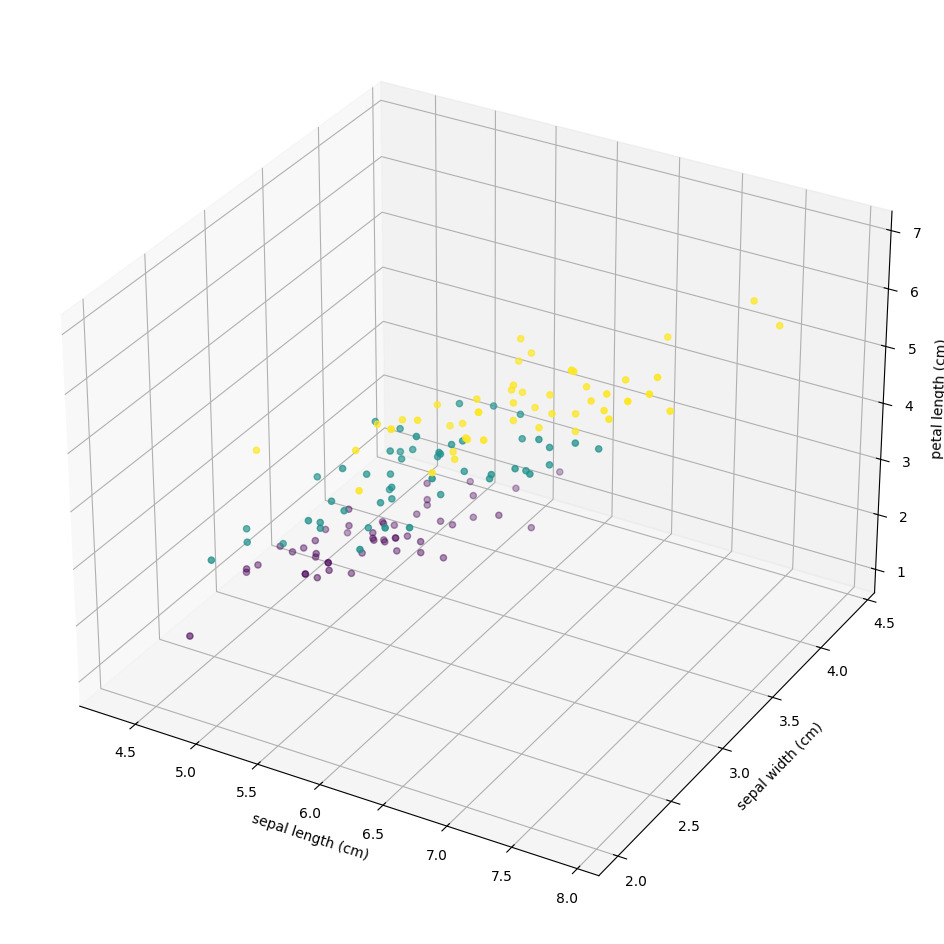

In [57]:
features = dataset.data
targets = dataset.target

fig = plt.figure(figsize=(12,12))
data_plot = fig.add_subplot(111, projection='3d')

data_plot.scatter(features[:, 0], features[:, 1], features[:, 2], c=targets, marker='o')
data_plot.set_xlabel(dataset.feature_names[0])
data_plot.set_ylabel(dataset.feature_names[1])
data_plot.set_zlabel(dataset.feature_names[2])



Let's see how the features are distributed.

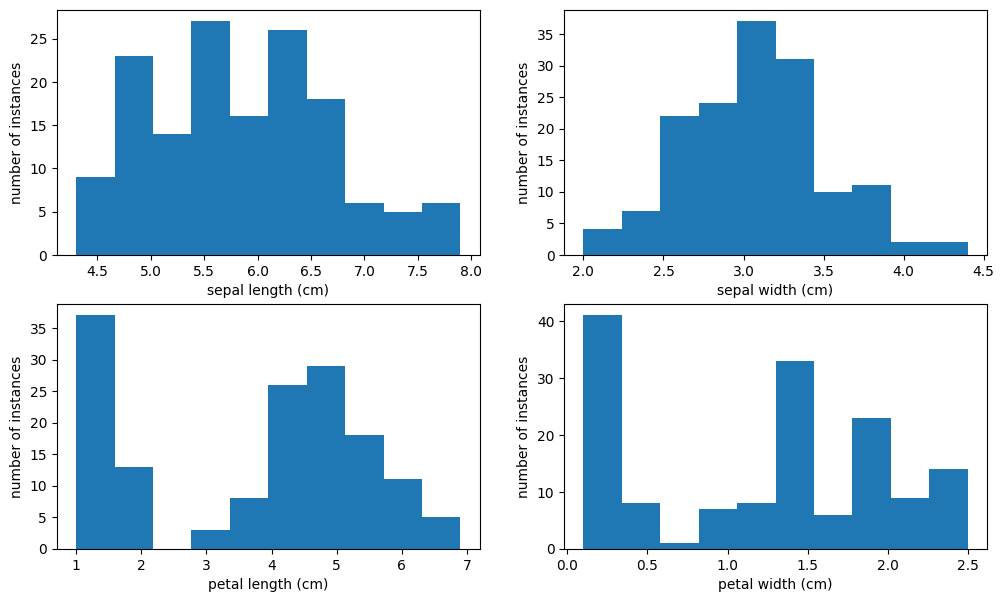

In [53]:
fig, subplots = plt.subplots(2, 2, figsize=(12, 7))
for itr, subplot in enumerate(subplots.flat):
    subplot.hist(features[:, itr])
    subplot.set_xlabel(dataset.feature_names[itr])
    subplot.set_ylabel('number of instances')

## Mathematical background

Bayesian classifiers use Bayes' theorem, which states that

$$
P(A | B) = \frac{P(B | A) P(A)}{P(B)}
$$

In the context of classification problems, for class $c_j$ and instance $d$, this can be rewritten as 

$$
P(c_j | d) = \frac{P(d | c_j) P(c_j)}{P(d)}
$$

where
* $P(c_j | d)$ is a probability of instance $d$ being in class $c_j$
* $P(d | c_j)$ is a probability of generating instance $d$ given class $c_j$ 
* $P(c_j)$ is a probability of occurrence of class $c_j$
* $P(d)$ is a probability of occurrence of instance $d$

The general algorithm is given an instance $d$, calculate $P(c_j | d)$ for each class $c_j$ and report the class with the highest probability as a prediction.

The term $P(d)$ can be calculated using the Law of total probabilities  given the total number of classes $C$ as

$$
P(d) = \sum_{i=1}^C P(d | c_i) P(c_i)
$$

This value will be the same for all the classes, thus it can be omitted. The probability then will be calculated using only the numerator of the initial fraction (we will normalize the probabilities later).

Each instance $d$ is composed of multiple features $d_1, d_2, ... d_N$, where each feature can be modelled with Gaussian distribution, the mean and standard deviation values of which we will calculate from the given sample. Each class will have its own model for each feature. Knowing that instance $d$ in reality is a vector $\mathbf{d} = [d_1, d_2, ... d_n]$, how do we calculate $P(\mathbf{d} | c_j)$? 

To simplify this calculation, naive Bayesian classifiers assume that features have independent distributions, and therefore estimate 

$$
P(\mathbf{d} | c_j) = \prod_{n=1}^N P(d_n | c_j) = P(d_1 | c_j) \times P(d_2 | c_j) \times \dots \times P(d_N | c_j)
$$

where $P(d_n | c_j)$ is a probability of instance $\bf{d}$ having this particular feature value $d_n$ given class $c_j$, which we obtain from the Gaussian disstribution for feature $d_n$ from the set of distrubtions for class $c_j$. Even though the values we obtain from the Gaussian distribution are not direct probabilites but rather values of the probability density function, this is a feasible probability estimate in the case of continuous variables. 

Finally, to calculate $P(c_j)$, we take the number of instances that belong to class $c_j$ and divide by the total number of instances in our sample.

## Implementation

Let's implement the `GaussianDistribution` class that will return us the probability of an istance being a particular class given a specific feature value.
Denote the Gaussian (or  normal) random variable as $\mathcal{N}(\mu, \sigma^2)$ with the following PDF:
$$
f(x|\mu, \sigma^2) = \frac{1}{\sigma\sqrt{2\pi}}\exp(-\frac{(x - \mu)^2}{2\sigma^2})
$$

To make calculations more efficient, we will perform them in the log space:

$$
\log P(c_j | \mathbf{d}) = \log P(\mathbf{d} | c_j) + \log P(c_j) - \log P(\mathbf{d})
$$ 

where $\log P(\mathbf{d} | c_j)$ now becomes

$$
\log P(\mathbf{d} | c_j) = \sum_{n=1}^N \log P(d_n | c_j) = \log P(d_1 | c_j) + \log P(d_2 | c_j) + \dots + \log P(d_N | c_j)
$$

In our implementatoin, we will not include $\log P(\mathbf{d})$ as discussed before, so the probabilities will not add up to 1, requiring normalization. For each class prediction $logpred(c_j) = log P(\mathbf{d} | c_j)$ of a particular instance $\mathbf{d}$, it will be normalized as $\frac{exp(logpred(c_j))}{\sum_{i=1}^C exp(logpred(c_i))}$.

Direct computation of the exponentials can lead to numerical instability, especially when the log-probabilities are very large or very small. To handle this, we use the log-sum-exp trick. In particular, the probability will be calculated as 

$$
exp(logpred(c_j) - logsumexp )
$$ 

where 
$$
logsumexp = \log \left( \sum_{i=1}^C exp(logpred(c_i))\right)
$$

We will be using the library implementaiton of log-sum-exp, but in essence, its purpose is to ensure that the arguments we pass to exp are within a manageable numerical range. To do so, in reality, log-sum-exp is calculated as 

$$
logsumexp = logpred_{max} + \log \left( \sum_{i=1}^C exp(logpred(c_i) - logpred_{max}) \right)
$$

where $logpred_{max}$ is the maximum value among all class predictions for a given instance.

Let's implement the `GaussianDistribution` class. For each pair of $(d_n, c_j)$ there will be a separate instance of that class that will return $\log P(d_n | c_j)$ for new values of feature $d_n$.

In [65]:
class GaussianDistribution:
    def __init__(self, feature):
        '''
        Args:
            feature: a column of the design matrix that consists of 
            all values for a given feature
        '''
        # Based on the feature values from instances of a particular class,
        # we model Gaussian distribution for that particular pair of (class, feature)
        self.mean = feature.mean(axis=0)
        self.std = feature.std(axis=0)
    
    def logpdf(self, value):
        # The log of the probability density functoin is used as a probability estimator
        return  - 0.5 * np.log(2. * np.pi * self.std**2) - (value - self.mean)**2 / (2 * self.std**2) 
    

Now let's implement the `NaiveBayes` class 

In [66]:
from sklearn.base import BaseEstimator, ClassifierMixin
from scipy.special import logsumexp

class NaiveBayes(BaseEstimator, ClassifierMixin):
    def fit(self, features, targets):
        self.unique_targets = np.unique(targets)
        # Each class c_j will have its own distribution for each feature that will allow us to calculate log P(d_n | c_j)
        # for a new value of feature d_n  
        self.conditional_feature_distributions = {}
        for target in self.unique_targets:
            # For a given class, this will store a distribution for each feature
            feature_distributions = []
            for feature_index in range(features.shape[1]):
                feature = features[targets == target, feature_index]
                distribution = GaussianDistribution(feature)
                feature_distributions.append(distribution)
            self.conditional_feature_distributions[target] = feature_distributions
        # Calculate P(c_j) for each class
        self.class_distributions = {
            target : sum((targets == target).astype(float)) / len(targets)
            for target in self.unique_targets
        }
    
    def predict_prob(self, features):
        # Class probabilities are computed for each instance
        class_probs_log = np.zeros((features.shape[0], len(self.unique_targets)), dtype=float)
        for target_index, target in enumerate(self.unique_targets):
            for feature in range(features.shape[1]):
                # A particular class probability is calculated simultaneously for all the instances
                # by summing over all the features
                class_probs_log[:, target] += self.conditional_feature_distributions[target][feature].logpdf(features[:, feature])
            # Finally, add log P(c_j) for a given class    
            class_probs_log[:, target] -= np.log(self.class_distributions[target])
        # Perform the log-sum-exp trick
        class_probs_log -= logsumexp(class_probs_log, axis=1, keepdims=True)
        # Return normalized probabilities
        return np.exp(class_probs_log)
    
    def predict(self, features):
        class_probs = self.predict_prob(features)
        # The prediction is returned as list, where for each instance, the class with the highest
        # probability is selected
        return np.array([self.unique_targets[target_index] for target_index in class_probs.argmax(axis=1)])

        

Let's test our Naive Bayes classifier on the unseed data. We will use `train_test_split` from `sklearn`.

In [67]:
from sklearn.model_selection import train_test_split
features_train, features_test, target_train, target_test = train_test_split(features, targets, test_size=0.25)

print(features_train.shape, features_test.shape)

(112, 4) (38, 4)


In [68]:
nb = NaiveBayes()
nb.fit(features_train, target_train)

In [73]:
print('Naive Bayes classifier accuracy on the train set: {}'.format(nb.score(features_train, target_train)))

Naive Bayes classifier accuracy on the train set: 0.9553571428571429


In [75]:
print('Naive Bayes classifier accuracy on the test set: {}'.format(nb.score(features_test, target_test)))

Naive Bayes classifier accuracy on the test set: 0.9736842105263158
